## 4. GLMのモデルの選択
複数の統計モデルから、何らかの意味で良いモデルを選ぶことを**モデル選択**と呼ぶ。  
ここでは、「良い予測をするモデルが良いモデルである」という考え方に基づいた**AIC**という基準について説明する。

### 4.1 データはひとつ、モデルはたくさん
3章では、架空植物100個体の種子数のデータを説明する統計モデルをいくつか作り、最尤推定を行った。  
- 体サイズ$x_i$が影響するモデル
- 施肥効果$f_i$が影響するモデル
- 体サイズと施肥効果が影響するモデル

ここでは、もう一つ追加して図に示す。
- 体サイズも施肥効果も影響しないモデル

In [374]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

d = pd.read_csv('C:/Users/tanak/study/参考書/データ解析のための統計モデリング/kubobook_2012/data/data3a.csv')
d.loc[d['f']=='C', 'f_dummy'] = 0
d.loc[d['f']=='T', 'f_dummy'] = 1

make_model = lambda data: sm.GLM(d.y, sm.add_constant(data), family=sm.families.Poisson())


model1 = make_model(d.x)
model2 = make_model(d.f_dummy)
model3 = make_model(d[['x', 'f_dummy']])
model4 = sm.GLM(d.y, np.ones(len(d)), family=sm.families.Poisson())

result1 = model1.fit()
result2 = model2.fit()
result3 = model3.fit()
result4 = model4.fit()

mdl_predict1 = lambda x: np.exp(result1.params[0]+result1.params[1]*x)
mdl_predict2 = lambda x, d: np.exp(result2.params[0]+result2.params[1]*d*x/x)
mdl_predict3 = lambda x, d: np.exp(result3.params[0]+result3.params[1]*x+result3.params[2]*d)
mdl_predict4 = lambda x: np.exp(result4.params[0]*x/x)

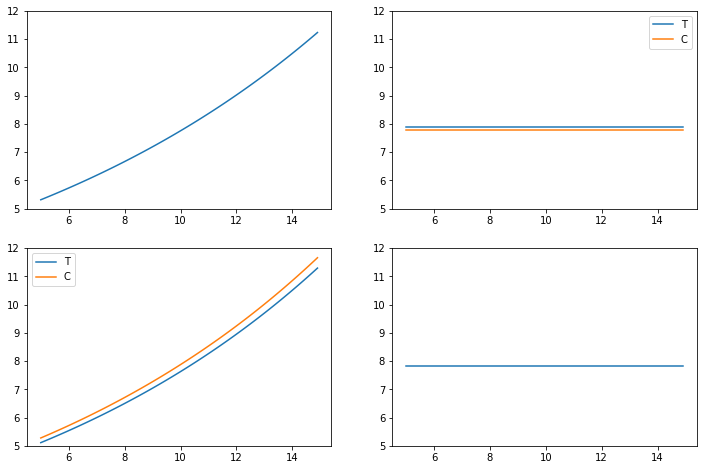

In [2]:
x = np.arange(5, 15, 0.1)

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(x, mdl_predict1(x));
ax1.set_ylim([5,12]);

ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(x, mdl_predict2(x, 1), label='T');
ax2.plot(x, mdl_predict2(x, 0), label='C');
ax2.set_ylim([5,12]);
ax2.legend();

ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(x, mdl_predict3(x, 1), label='T');
ax3.plot(x, mdl_predict3(x, 0), label='C');
ax3.set_ylim([5,12]);
ax3.legend();

ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(x, mdl_predict4(x));
ax4.set_ylim([5,12]);

対数尤度が「いま手元にある観測データへの当てはまりの良さ」であると考え、これを最大にするパラメータを探してきた。  
最大対数尤度つまり「当てはまりの良さ」こそがモデルの良さであると考えればよいか？

### 4.2 統計モデルのあてはまりの悪さ：逸脱度
モデルの「あてはまりの良さ」ではなく「あてはまりの悪さ」を表現する**逸脱度**は、
$$
D=-2\log{L^*}
$$
と定義される。  
ここで、対数尤度を$\log{L}$としたときに、最大対数尤度を$\log{L^*}$と表記している。  
たとえば体サイズだけに依存するモデルを「xモデル」と呼ぶことにすると、  
このモデルの最大対数尤度は-235.4くらいであったので、逸脱度はおよそ470.8と計算できる。

また、**残差逸脱度**は、「あてはまりの悪さの相対値」であり、次のように定義される。
$$
D-(ポアソン分布モデルで可能な最小逸脱度)
$$
ここで、「ポアソン分布モデルで可能な最小逸脱度」とは  
フルモデル(データ数が100個なのでパラメータ100個を使ってあてはめたモデル)の逸脱度である。

In [20]:
from scipy.stats import poisson

prob = poisson.pmf(d.y, mu=d.y)

logL = np.sum(np.log(prob))
D = -2*logL
print(logL)
print("逸脱度: ", D)

-192.88975252449595
逸脱度:  385.7795050489919


In [23]:
print("逸脱度: ", -2*(-235.39))
print("残差逸脱度: ", (-2*(-235.39))-385.78)
result1.summary()

逸脱度:  470.78
残差逸脱度:  85.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -235.39
Date:                Mon, 18 Oct 2021   Deviance:                       84.993
Time:                        00:33:44   Pearson chi2:                     83.8
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2917      0.364      3.552      0.000       0.579       2.005
x              0.0757      0.036      2.125      0.034       0.006       0.145
==============================================================================
"""

次に、残差逸脱度が最大となるのは最もあてはまりの悪いモデルである。  
今回の場合では、最もパラメータの少ないモデルは切片のみのモデル(nullモデル)である。

In [24]:
print("逸脱度: ", -2*(-237.64))
print("残差逸脱度: ", (-2*(-237.64))-385.78)
result4.summary()

逸脱度:  475.28
残差逸脱度:  89.5


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -237.64
Date:                Mon, 18 Oct 2021   Deviance:                       89.507
Time:                        00:33:54   Pearson chi2:                     87.1
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0580      0.036     57.586      0.000       1.988       2.128
==============================================================================
"""

残差逸脱度の最大値は89.5となる。  
  
パラメータの数($k$)を増やせば残差逸脱度は小さくなり当てはまりが良くなる。

### 4.3 モデルの選択基準 AIC
パラメータの数の多い統計モデルほど、データへの当てはまりがよくなるが、「予測の良さ」をそこなっている可能性がある。  
ここでは、モデルの選択基準のひとつ**AIC(Akaike's information criterion)**を説明する。  
AICは当てはまりの良さではなく、予測の良さを重視するモデル選択基準である。  
$$
\begin{align}
AIC&=-2\{(最大対数尤度)-(最尤推定したパラメータ数)\}\\
&=-2(\log{L^*}-k)\\
&=D+2k
\end{align}
$$

AICが一番小さいモデルが良いモデルとなる。  
今回の例題では、xのみを使ったモデルがAIC最小のモデルとなる。

In [31]:
print("null: ", result4.aic)
print("x: ", result1.aic)
print("f: ", result2.aic)
print("x+f: ", result3.aic)
print("full: ", D+2*100)

null:  477.2864426185734
x:  474.7725015397216
f:  479.25451392137364
x+f:  476.58743848498733
full:  585.779505048992


#### 4.4 AICの説明のための別の例題
観測データには、個体$i$の種子数$y_i$と体サイズ$x_i$が50個体ぶん含まれている。  
応答変数$y_i$は、ポアソン分布に従っているものとする。  
また、説明変数$x_i$は、種子数$y_i$とは関係ないものとする。  
ここで、2つのモデルを考える。
- $\log{\lambda}_i=\beta_1$　…　一定モデル(k=1)
- $\log{\lambda}_i=\beta_1+\beta_2x_i$　…　xモデル(k=2)

一方のモデルが他方に含められているとき、これらのモデルは**ネスト**しているモデルと呼ぶ。

In [77]:
data2 = pd.DataFrame({"y":np.random.poisson(8, 50),
                      "x":np.random.uniform(-2, 2, 50)})
data2.head()

,y,x
0,7,0.744037
1,6,0.407414
2,7,-1.702211
3,5,1.549428
4,8,-1.890381


In [78]:
make_model = lambda data: sm.GLM(data2.y, sm.add_constant(data), family=sm.families.Poisson())

model1 = make_model(data2.x)
model2 = sm.GLM(data2.y, np.ones(len(data2)), family=sm.families.Poisson())

result1 = model1.fit()
result2 = model2.fit()

mdl_predict1 = lambda x: np.exp(result1.params[0]+result1.params[1]*x)
mdl_predict2 = lambda x: np.exp(result2.params[0]*x/x)

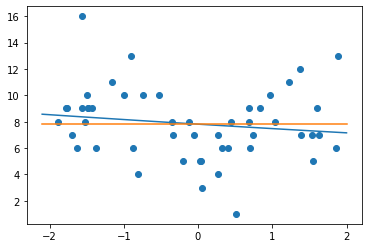

In [79]:
x = np.arange(-2.1, 2.1, 0.1)

plt.scatter(data2.x, data2.y)
plt.plot(x, mdl_predict1(x));
plt.plot(x, mdl_predict2(x));

### 4.5 なぜAICモデルを選択してよいか
#### 平均対数尤度
平均対数尤度はモデルの予測の良さを表す量である。  
観測データを使って一定モデルのパラメータ$\beta_1$の最尤推定を行う。  
平均種子数は$\lambda_i=\exp{\beta_1}$で決まる。  
パラメータ最尤推定法は、対数尤度を最大にする最尤推定値$\hat{\beta_1}$を見つけることである。  
真の統計モデル(生成したモデル)では、平均$\lambda$は8と設定しているので、$\beta_1=\log{8}=2.08$となる。  
この50個の観測データを使って最尤推定された$\hat{\beta_1}$は、2.06となった。

beta:  2.06


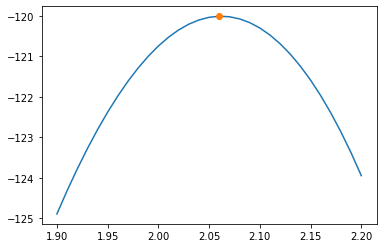

In [82]:
x = np.arange(1.9, 2.2, 0.01)

probs = [np.sum(np.log(poisson.pmf(data2.y, mu=i))) for i in np.exp(x)]
max_id = np.argmax(probs)
print("beta: ", x[max_id])

plt.plot(x, probs);
plt.plot(x[max_id], probs[max_id], 'o');

推定されたモデルが真の統計モデルにどれぐらい近いのかを調べる方法として、予測の良さを推定する。  
今回は真の統計モデルが分かっているので、予測の良さの評価用データを200セット生成する。  
これらのデータに対し、すでに推定された一定モデル$\hat{\beta_1}=2.06$の当てはまりの良さを対数尤度で評価する。  
これらの200個の対数尤度の平均が**平均対数尤度**であり、$E(\log{L})$と書くこととする。

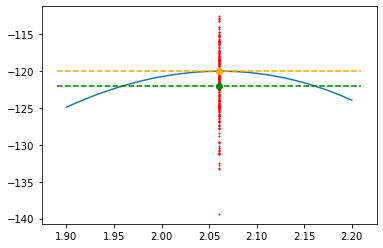

In [112]:
datasets = [np.random.poisson(8, 50) for i in range(200)]

Elog = [np.sum(np.log(poisson.pmf(d, mu=np.exp(2.06)))) for d in datasets]
mean_Elog = np.mean(Elog)

plt.plot(x, probs);
plt.plot([2.06]*200, Elog, 'o', markersize=1, color='red')
plt.plot(x[max_id], probs[max_id], 'o', color='orange');
plt.plot([1.89, 2.21], [probs[max_id], probs[max_id]], '--', color='orange')
plt.plot(2.06, mean_Elog, 'o', color='green');
plt.plot([1.89, 2.21], [mean_Elog, mean_Elog], '--', color='green')

平均対数尤度は-121.96となり、偶然得られた観測データで推定されたモデルでは当てはまりの良さが過大評価されていることとなる。  
ここで、
1. 真の統計モデルからパラメータ推定用データ1セットを生成
2. 一定モデルを推定
3. 真の統計モデルから予測の良さ評価用データ200セットを生成
4. 平均対数尤度を評価

という操作を12回繰り返す。  
最大対数尤度と平均対数尤度はどちらが大きいあるいは小さいとは言えない。

In [126]:
def make_logL():
    x = np.arange(1.9, 2.2, 0.01)
    d = np.random.poisson(8, 50)
    probs = [np.sum(np.log(poisson.pmf(d, mu=i))) for i in np.exp(x)]
    max_id = np.argmax(probs)
    beta = x[max_id]

    datasets = [np.random.poisson(8, 50) for i in range(200)]

    Elog = [np.sum(np.log(poisson.pmf(d, mu=np.exp(beta)))) for d in datasets]
    mean_Elog = np.mean(Elog)
    return beta, mean_Elog, probs[max_id], Elog

In [127]:
results = [make_logL() for i in range(12)]

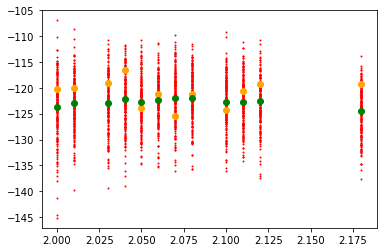

In [135]:
for i in range(12):
    res = results[i]
    plt.plot([res[0]]*200, res[3], 'o', markersize=1, color='red')
    plt.plot(res[0], res[2], 'o', markersize=6, color='orange');
    plt.plot(res[0], res[1], 'o', markersize=6, color='green');

同じ操作を200回繰り返し、最大対数尤度と平均対数尤度の差の分布を確認する。  
このとき、この差を**バイアス**と呼び、  
$$
b=\log{L^*}-E(\log{L})
$$

と定義する。

In [144]:
results2 = [make_logL() for i in range(200)]
diff = [r[2]-r[1] for r in results2]
print('標本平均', np.mean(diff))

標本平均 0.7661927572861009


標本平均は0.77であり、分布は以下のようになる。

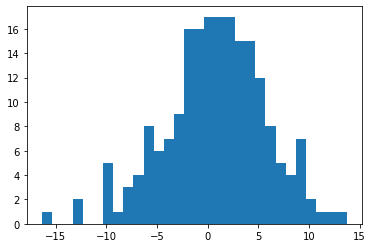

In [145]:
plt.hist(diff, bins=30);

実際は真の統計モデルが不明であるため、$E(\log{L})$がどのような値になるかはわからない。  
ここで、バイアス$b$の定義を変形すると、
$$
E(\log{L})=\log{L^*}-b
$$

となり、平均的な$b$と最大対数尤度$\log{L^*}$の値がわかれば、平均対数尤度の推定量が得られる。  
これを**バイアス補正**と呼ぶ。  
  
一般的には、最尤推定するパラメータを$k$個もつモデルの平均対数尤度の推定量は$\log{L^*}-k$であることが分かっている。  
今回の一定モデルでは、$k=1$であるので、
$$
E(\log{L})=\log{L^*}-1
$$

であり、これに-2を掛けたものがAICとなる。
$$
AIC=-2×(\log{L^*}-1)
$$

平均対数尤度が「モデルの予測の良さ」であったから、AICは「予測の悪さ」と解釈できる。  
したがってAICが小さいほど予測が良いモデルということになる。

#### ネストしているGLM間のAIC
- $\log{\lambda}_i=\beta_1$　…　一定モデル(k=1)
- $\log{\lambda}_i=\beta_1+\beta_2x_i$　…　xモデル(k=2)

In [591]:
def make_logL1(d, datasets):
    b1 = np.arange(1.9, 2.2, 0.01)
    
    probs = [np.sum(np.log(poisson.pmf(d, mu=i))) for i in np.exp(b1)]
    
    max_id = np.argmax(probs)
    beta = b1[max_id]

    Elog = [np.sum(np.log(poisson.pmf(d, mu=np.exp(beta)))) for d in datasets]
    mean_Elog = np.mean(Elog)
    return mean_Elog, probs[max_id], Elog

def make_logL2(d, datasets):
    b1 = np.arange(1.9, 2.2, 0.01)
    b2 = np.arange(-0.1, 0.016, 0.001)
    
    #xi = np.random.uniform(-2, 2, 50)
    xi = np.random.normal(0, 1, 50)
    probs = np.array([[np.sum(np.log(poisson.pmf(d, mu=np.exp(beta1+xi*beta2)))) for beta1 in b1] for beta2 in b2])
    max_id = np.unravel_index(np.argmax(probs, axis=None), probs.shape)
    
    mb1 = b1[max_id[1]]
    mb2 = b2[max_id[0]]

    #xis = [np.random.uniform(-2, 2, 50) for _ in range(200)]
    xis = [np.random.normal(0, 1, 50) for _ in range(200)]
    
    Elog = [np.sum(np.log(poisson.pmf(d, mu=np.exp(mb1 + mb2*x)))) for d, x in zip(datasets, xis)]
    mean_Elog = np.mean(Elog)
    return mean_Elog, probs[max_id], Elog

In [595]:
diff_maxL = []
diff_meanL = []
diff_b = []
for _ in range(200):
    d = np.random.poisson(8, 50)
    datasets = [np.random.poisson(8, 50) for i in range(200)]
    
    nullL = make_logL1(d, datasets)
    xL = make_logL2(d, datasets)
    
    diff_maxL.append(xL[1]-nullL[1])
    diff_meanL.append(xL[0]-nullL[0])
    diff_b.append((xL[1]-xL[0])-(nullL[1]-nullL[0]))

あてはまりの良さである最大対数尤度の比較を行うために、
$$
(xモデルの\log{L^*})-(一定モデルの\log{L^*})
$$

の分布をみるとパラメータ数の多いxモデルのほうが高くなる。

0.2901318879078702


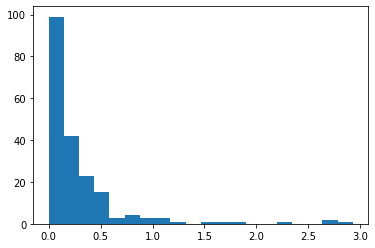

In [596]:
print(np.mean(diff_maxL))
plt.hist(diff_maxL, bins=20);

予測能力を表す平均対数尤度の比較を行うために、
$$
(xモデルのE(\log{L}))-(一定モデルのE(\log{L}))
$$

の分布をみると、パラメータ数の多いxモデルのほうが低くなる。

-0.22557423217906497


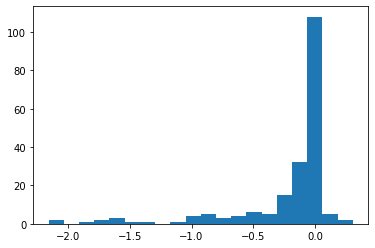

In [597]:
print(np.mean(diff_meanL))
plt.hist(diff_meanL, bins=20);

また、バイアスの差を見ると増加していることが分かる。

0.5157061200869352


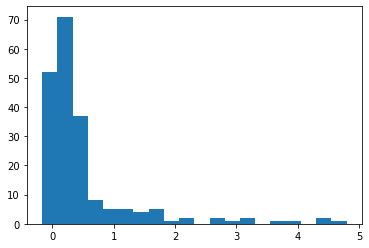

In [598]:
print(np.mean(diff_b))
plt.hist(diff_b, bins=20);